The packages necessary for the simulation  
Un-comment the first line (cell) to update the package. Updating the package is necessary when running first time for HW3  
After running first time, comment it again and run the below cells

In [ ]:
#using Pkg;Pkg.rm("JutulDarcyAD");Pkg.add(url = "https://github.com/slimgroup/JutulDarcyAD.jl.git", rev = "up-jutul")

In [1]:
using PyPlot, JutulDarcyAD, LinearAlgebra, JLD2, Polynomials

In [2]:
#Get velocity model
if ~isfile("BGCompass_tti.jld2")
    run(`wget https://www.dropbox.com/s/hc0ergw2ybbrajr/BGCompass_tti.jld2\?dl=0 -q -O BGCompass_tti.jld2`)
else
    JLD2.@load "BGCompass_tti.jld2" m d
end

2-element Vector{Symbol}:
 :m
 :d

In [3]:
#Some necessary type conversions and defining size of velocity
v = Float64.(sqrt.(1f0./m));
d = Float64.(d);
n = size(v)

(325, 171)

In [4]:
#A basic funtion to find water bottom layer index values (You do not need to modify this)
function find_water_bottom(m::AbstractArray{avDT,2};eps = 1e-4) where {avDT}
    #return the indices of the water bottom of a seismic image
    n = size(m)
    idx = zeros(Integer, n[1])
    for j=1:n[1]
        k=1
        while true
            if abs(m[j,k]) > eps
                idx[j] = k
                break
            end
            k += 1
        end
    end
    return idx
end

# Changig velocity model to permeability
function VtoK(v::Matrix{T}, d::Tuple{T, T}; α::T=T(10)) where T

    n = size(v)
    idx_wb = find_water_bottom(v.-minimum(v))
    idx_ucfmt = find_water_bottom((v.-T(3.5)).*(v.>T(3.5)))
    Kh = zeros(T, n)
    capgrid = Int(round(T(50)/d[2]))
    for i = 1:n[1]
        Kh[i,1:idx_wb[i]-1] .= T(1e-10)  # water layer
        Kh[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1] .= α*exp.(v[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1])
        Kh[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] .= T(1e-3)
        Kh[i,idx_ucfmt[i]:end] .= α*exp.(v[i,idx_ucfmt[i]:end]) .- T(320)
    end
    return Kh
end
Kh = VtoK(v, d);

# This part is used to create porosity (You do not need to modify this)
idx_wb = find_water_bottom(v.-minimum(v));
idx_ucfmt = find_water_bottom((v.-3.5).*(v.>3.5))
phi = zeros(Float64,n)
for i = 1:n[1]
    for j = 1:n[2]
        p = Polynomial([-0.0314^2*Kh[i,j],2*0.0314^2*Kh[i,j],-0.0314^2*Kh[i,j],1.527^2]) 
        phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
    end
    for j = idx_ucfmt[i]:idx_ucfmt[i]+8
        phi[i,idx_ucfmt[i]:idx_ucfmt[i]+8] = Float64.(range(0.056,stop=0.1,length=9))
    end
end

In [5]:
# We will use a subset of permeability model to make simulation faster .
Kh = Kh[151:240, :]
K = Float64.(Kh * md);
n = (size(K,1), 1, size(K,2))
d = (d[1], 50.0, d[2])
phi = phi[151:240, :]
phi_m = convert(Array{Float64,1},vec(phi));
ϕ = phi

# We set boundary values of porosity to 1e8. This will prevent over pressurization.
ϕ[1,:] .= 1e8
ϕ[:,1] .= 1e8
ϕ[end,:] .= 1e8
ϕ[:,end] .= 1e8
ϕ = convert(Array{Float64,1},vec(ϕ));

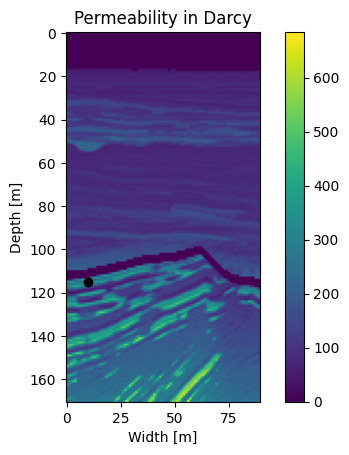

PyObject <matplotlib.collections.PathCollection object at 0x7fc3f78e4820>

In [6]:
#Plot permeability map 
i=10
imshow(Kh'); colorbar(); xlabel("Width [12.5m]"); ylabel("Depth [12.5m]"); title("Permeability in Darcy (Grids size 12.5m)")
scatter(i,idx_ucfmt[i+150], c= "k")

In [7]:
# Create the model
model = jutulModel(n, d, ϕ, K1to3(K))

jutulModel{3, Float64}((90, 1, 171), (12.5, 50.0, 12.5), [1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8  …  1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8], [9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13], 0.0)

In [ ]:
# simulation
tstep = 500 * ones(2) # This corresponds to 1000 days. 500 is dt and 3 is number of time steps. 

#You will add 1000 more steps in each simulation run so we only define it in this cell.
tot_time = sum(tstep)

## injection & production (source & sink) location
inj_loc = (5, 1, n[end]-10) .* d

# injectivity is in m^3 per sec
irate = 8e-1
q = jutulForce(irate, [inj_loc])

## set up modeling operator
S = jutulModeling(model, tstep)
Trans = KtoTrans(CartesianMesh(model), K1to3(K))

In [8]:
# First Step
@time state = S(log.(Trans), q; info_level=1)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))
println("Pressure below seal for a specific point: ", point_pressure)

Jutul: Simulating 142 weeks, 6 days as 2 report steps
Step 1/2: Solving start to 71 weeks, 3 days, Δt = 71 weeks, 3 days 


┌ Warning: Linear solver: Breakdown bᴴc = 0, final residual: 795.9739495585411, rel. value 1.0. rtol = 0.001, atol = 0.0, max_it = 200, solver = bicgstab
└ @ Jutul ~/.julia/packages/Jutul/jYVS2/src/linsolve/krylov.jl:156


Step 2/2: Solving 71 weeks, 3 days to 142 weeks, 6 days, Δt = 71 weeks, 3 days 
Simulation complete: Completed 2 timesteps in 1 minute, 546 milliseconds and 143 iterations.
╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 27 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     71.5 │       5.2963 │ 423.3948 │  143 (0) │
│ Linearization  │     85.0 │       6.2963 │ 356.1497 │  170 (0) │
│ Linear solver  │    170.5 │      12.6296 │ 177.5527 │  341 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭──────────────┬──────────┬────────────┬─────────╮
│ Timing type  │     Each │   Relative │   Total │
│              │       ms │ Percentage │       s │
├──────────────┼──────────┼────────────┼─────────┤
│ Properties   │  13.5633 │     3.20 % │  1.9396 │
│ Equations    │  54.4670 │    15.29

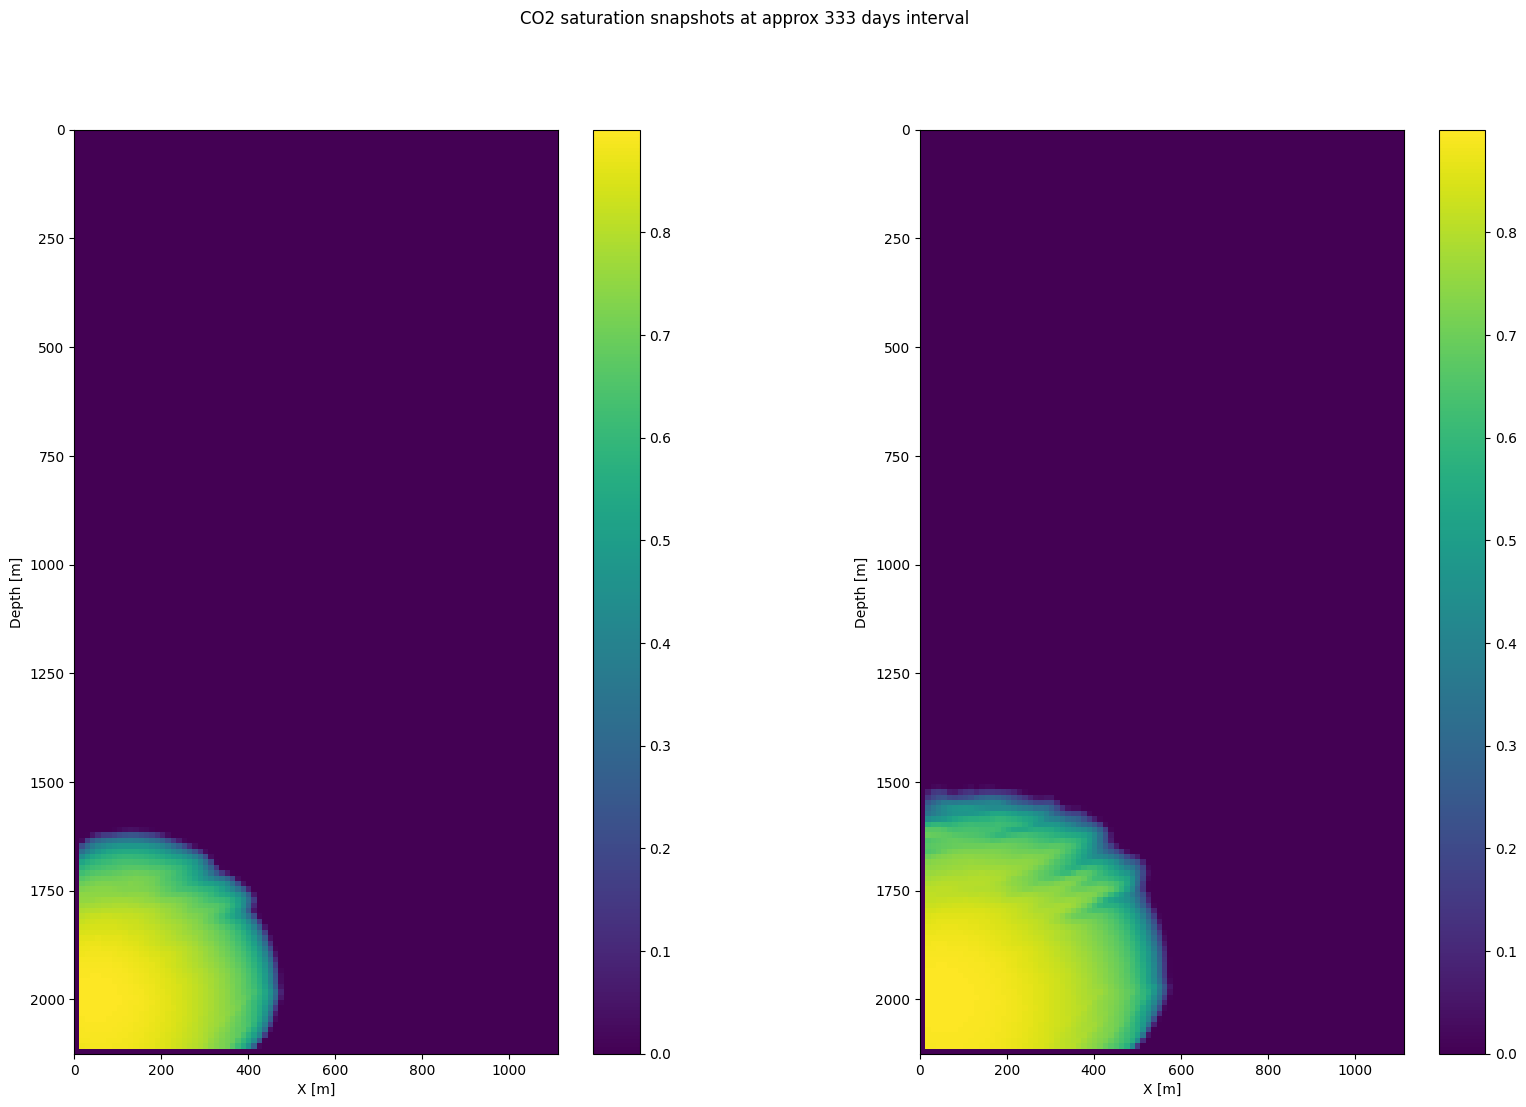

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval')

In [11]:
# Plot first step saturation results
figure(figsize=(20,12));
obs=[1,2]
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval")

In [12]:
# Second Step
#Keep injection rate as high as possible but also consider the pressure criterion
irate = 9e-1
q2 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q2; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204


╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 10 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     26.0 │          5.2 │ 107.5785 │   52 (0) │
│ Linearization  │     31.0 │          6.2 │  90.2271 │   62 (0) │
│ Linear solver  │     65.0 │         13.0 │  43.0314 │  130 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭──────────────┬──────────┬────────────┬────────╮
│ Timing type  │     Each │   Relative │  Total │
│              │       ms │ Percentage │      s │
├──────────────┼──────────┼────────────┼────────┤
│ Properties   │  13.3296 │    12.39 % │ 0.6931 │
│ Equations    │   2.7555 │     3.05 % │ 0.1708 │
│ Assembly     │   1.5231 │     1.69 % │ 0.0944 │
│ Linear solve │  87.1720 │    81.03 % │ 4.5329 │
│ Update       │   1.2467 │     1.16 % │ 0.0648 │
│ Convergence 

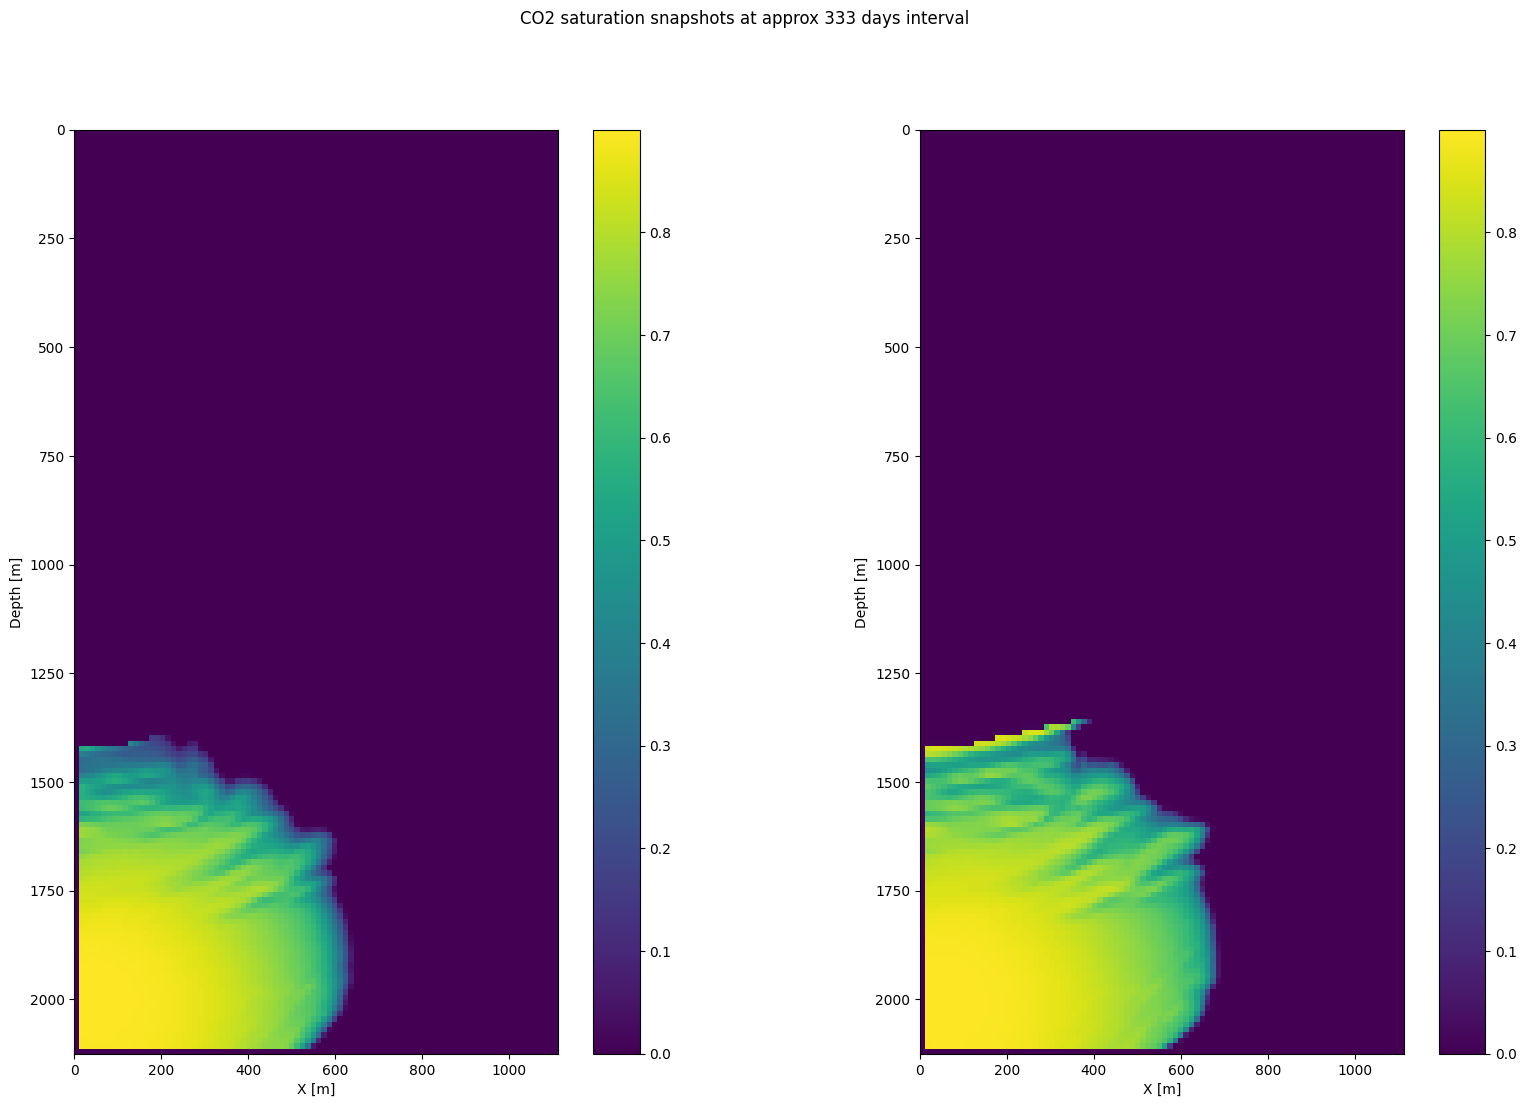

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval')

In [13]:
# Plot second step saturation results
figure(figsize=(20,12));
obs=[1,2]
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval")

In [14]:
# Third Step
#Keep injection rate as high as possible but also consider the pressure criterion
irate = 50e-2
q3 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q3;state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204


╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 14 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     44.0 │      6.28571 │ 165.4501 │  88 (15) │
│ Linearization  │     51.0 │      7.28571 │ 142.7413 │ 102 (16) │
│ Linear solver  │    126.0 │         18.0 │  57.7762 │ 252 (37) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭──────────────┬──────────┬────────────┬─────────╮
│ Timing type  │     Each │   Relative │   Total │
│              │       ms │ Percentage │       s │
├──────────────┼──────────┼────────────┼─────────┤
│ Properties   │  16.3598 │     9.89 % │  1.4397 │
│ Equations    │   3.3114 │     2.32 % │  0.3378 │
│ Assembly     │   2.0861 │     1.46 % │  0.2128 │
│ Linear solve │ 133.8891 │    80.92 % │ 11.7822 │
│ Update       │   1.4192 │     0.86 % │  0.1249 │
│ Con

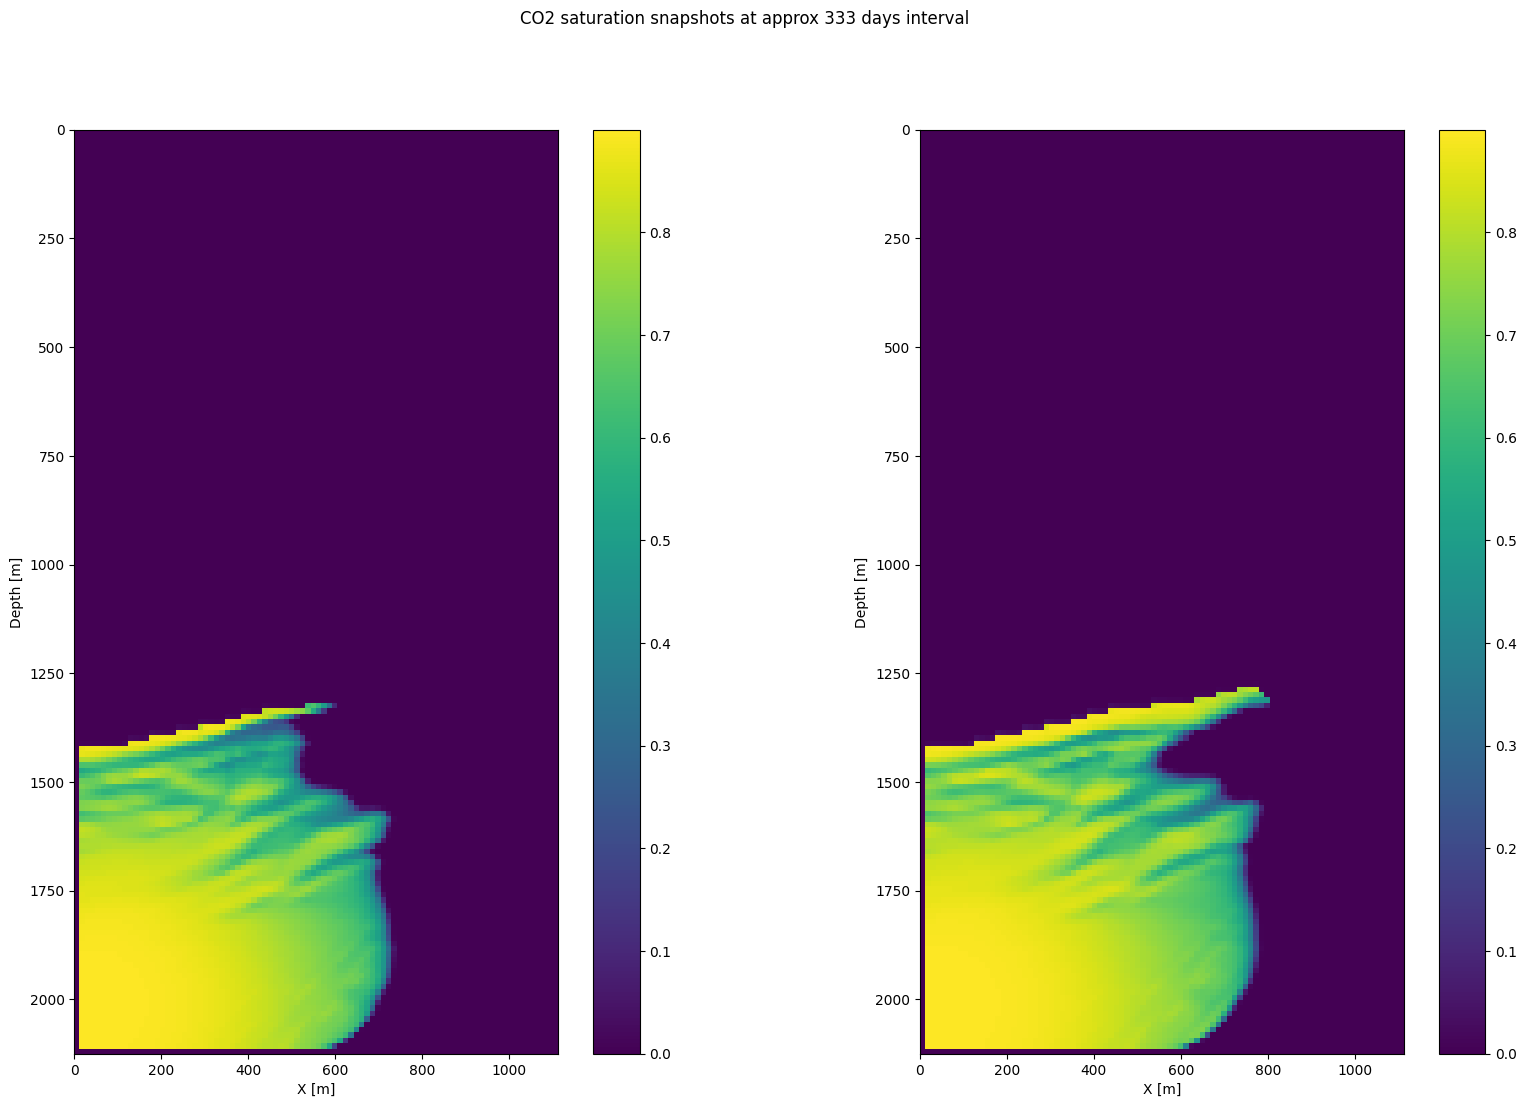

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval')

In [15]:
# Plot third step saturation results
figure(figsize=(20,12));
obs=[1,2]
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval")

In [16]:
# Fourth Step
#Keep injection rate as high as possible but also consider the pressure criterion
irate = 50e-2
q4 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q4; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204


╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 16 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     45.0 │        5.625 │ 131.0797 │   90 (0) │
│ Linearization  │     53.0 │        6.625 │ 111.2941 │  106 (0) │
│ Linear solver  │    128.0 │         16.0 │  46.0827 │  256 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭──────────────┬──────────┬────────────┬─────────╮
│ Timing type  │     Each │   Relative │   Total │
│              │       ms │ Percentage │       s │
├──────────────┼──────────┼────────────┼─────────┤
│ Properties   │  15.8415 │    12.09 % │  1.4257 │
│ Equations    │   3.2655 │     2.93 % │  0.3461 │
│ Assembly     │   2.2331 │     2.01 % │  0.2367 │
│ Linear solve │ 106.4480 │    81.21 % │  9.5803 │
│ Update       │   1.4197 │     1.08 % │  0.1278 │
│ Con

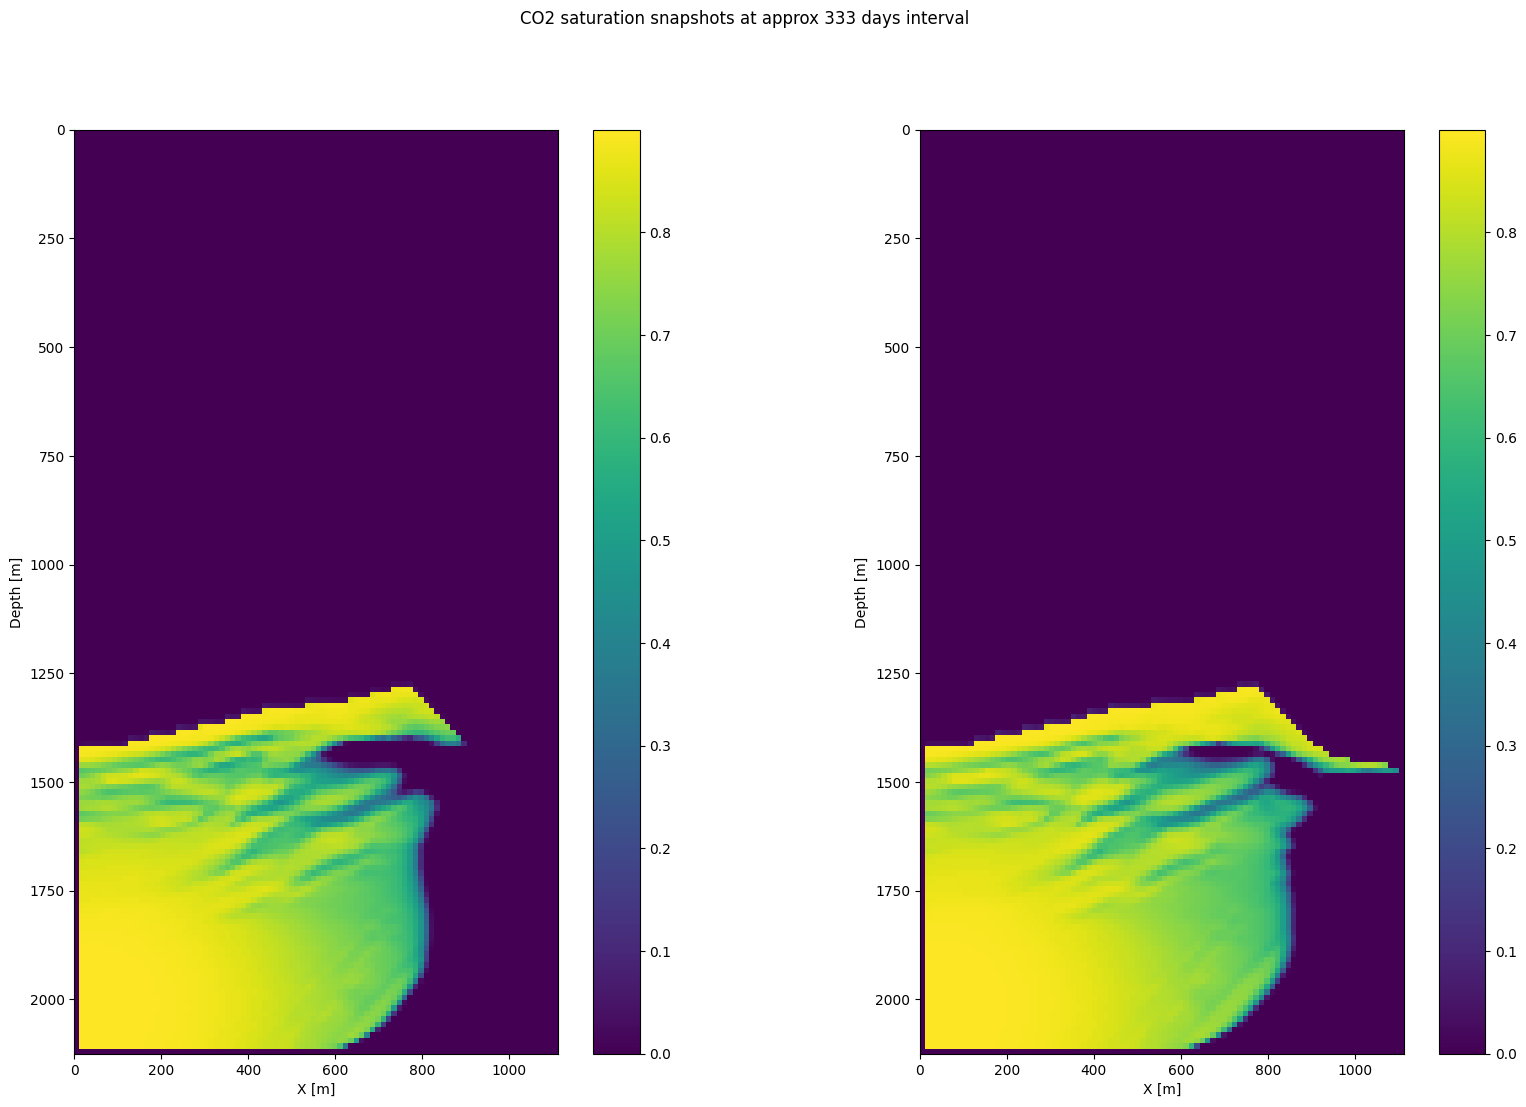

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval')

In [17]:
# Plot fourth step saturation results
figure(figsize=(20,12));
obs=[1,2]
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval")

In [18]:
# Fifth Step
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))
irate = 50e-2
q5 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q5; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
#@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204
┌ Warning: Producer Injector is injecting?
└ @ JutulDarcy ~/.julia/packages/JutulDarcy/nBFWd/src/facility/cross_terms.jl:204


╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 13 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     28.0 │      4.30769 │ 136.2614 │   56 (0) │
│ Linearization  │     34.5 │      5.30769 │ 110.5890 │   69 (0) │
│ Linear solver  │     82.0 │      12.6154 │  46.5283 │  164 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭──────────────┬──────────┬────────────┬────────╮
│ Timing type  │     Each │   Relative │  Total │
│              │       ms │ Percentage │      s │
├──────────────┼──────────┼────────────┼────────┤
│ Properties   │  11.5583 │     8.48 % │ 0.6473 │
│ Equations    │   2.5328 │     2.29 % │ 0.1748 │
│ Assembly     │   1.9875 │     1.80 % │ 0.1371 │
│ Linear solve │ 116.7768 │    85.70 % │ 6.5395 │
│ Update       │   1.3314 │     0.98 % │ 0.0746 │
│ Convergence 

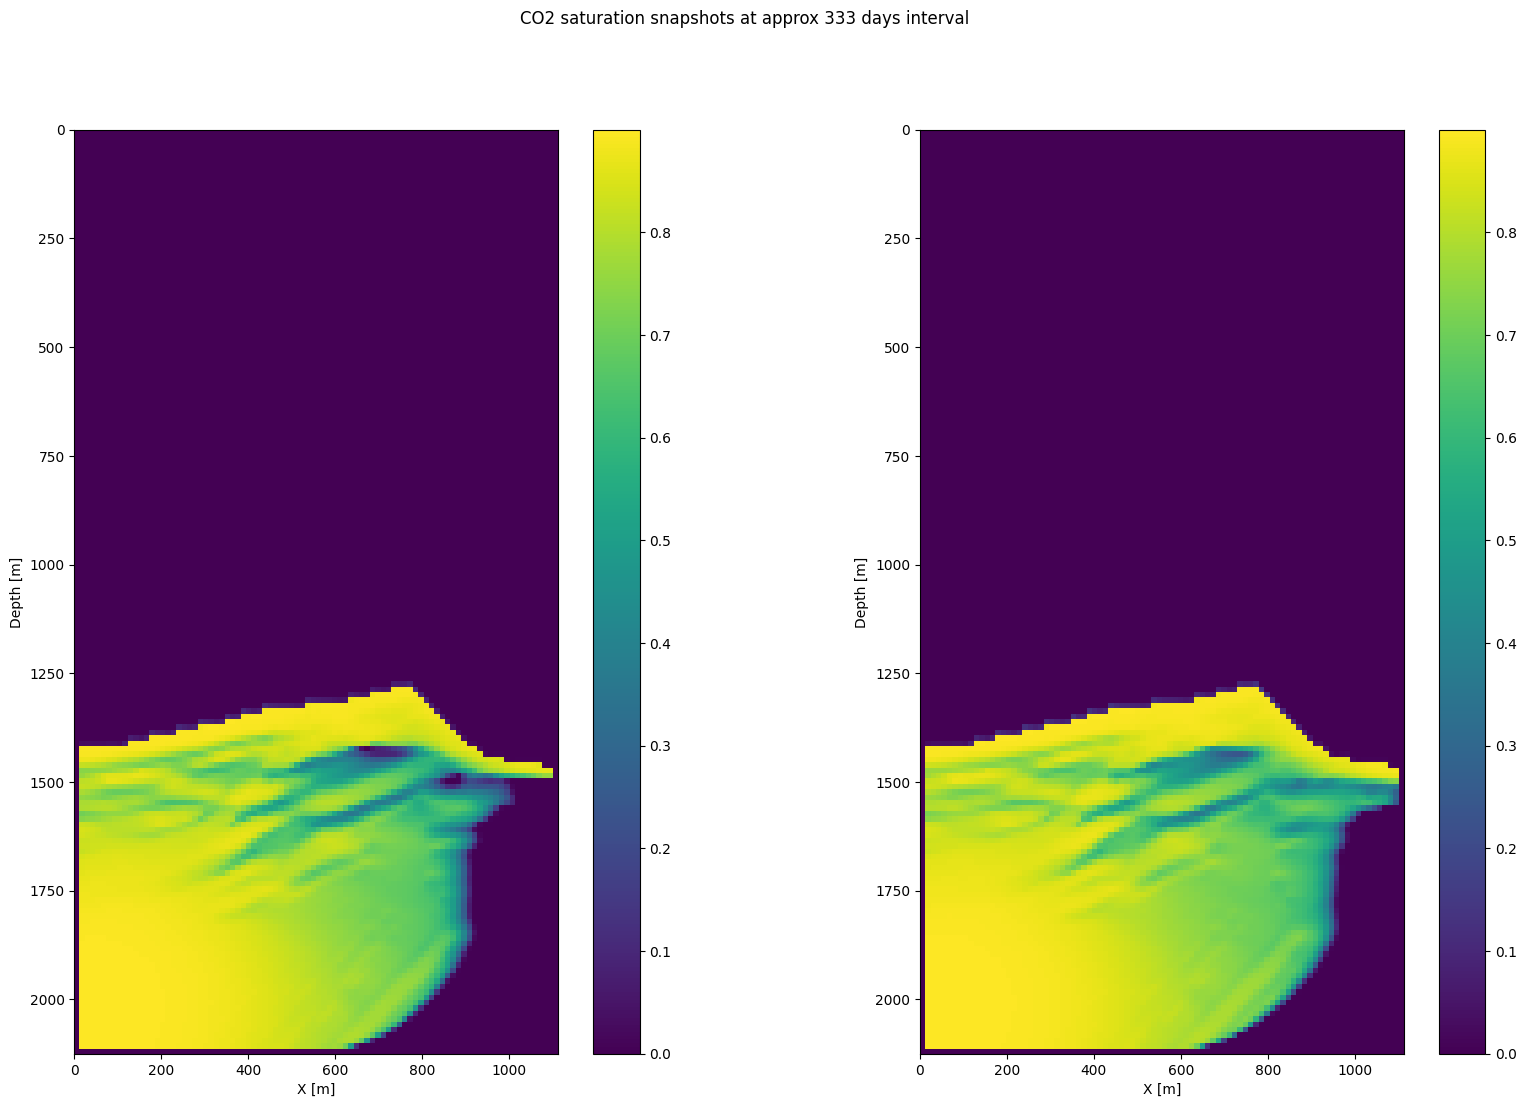

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval')

In [19]:
# Plot fifth step saturation results
figure(figsize=(20,12));
obs=[1,2]
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval")

# Question  
Goal of this homework is to maximize the volume of $CO_{2}$ injected. There are 5 simulation steps with corresponding plots of saturation. Each step has an irate which is injectivity rate.  
In each step, the simulation will check the pressure, if it is between 13 Mpa and 15 MPa and will output true. If it is not in this range it will output false.  
The code will also output the pressure value.  
Start from the first step, check simulation output to be true or false and then check the pressure value. If it is higher than 15 MPa, decrease irate in next simualtion step or vice cersa.  
Repeat and run all the steps and calculate the total injected volume using the formula below.  
Remember we need to maximize injectivity, so you may need to repeat the whole experiment with different irate for each step and see what combination of irate injects maximum CO2 to reservoir without exceeding fracture pressure of 15 MPa.

In [ ]:
sum(Saturations(state.states[end]).*phi_m)*prod(model.d)